<a href="https://colab.research.google.com/github/PeterSpitz/cap-comp215/blob/main/comp_project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#imports for graphs
import matplotlib
import matplotlib.pyplot as plt
import datetime, json, requests, math
from pprint import pprint    # Pretty Print - built-in python function to nicely format data structures

In [29]:
#must have valid inputs
START_DATE = "2026-01-01" #yyyy-mm-dd returns one week of data
UPPER_DATE = "2040-01-01" #upper and lower are the window for the time period to be examined.
LOWER_DATE = "2020-01-01" #Do not make window too large or the graph will become unreadable

#can be set to None if unwanted
ASTEROID_ID = 54576476 #int. set to None to skip search
ASTEROID_NAME = "(2026 BC)" #str. set to None to skip search
#if name and id are both set, but point to different asteroids the search will fail
DANGEROUS = None #bool. any value other than True/False skips search
ORBITING_BODY = None #str. set to None to skip search

In [3]:
API_KEY = 'S896m0XG5ds8v5gN97Gsa8Fh8YrnXrIpPEoqnkPF'

def get_neos(start_date):
    """ Return a list of NEO for the week starting at start_date """
    url = f'https://api.nasa.gov/neo/rest/v1/feed?start_date={start_date}&api_key={API_KEY}'
    # Fetch last week's NEO feed
    response = requests.request("GET", url, headers={}, data={})
    data = json.loads(response.text)
    return [neo for dated_records in data['near_earth_objects'].values() for neo in dated_records ]

def get_neo(id):
    """ Return a NEO record for the given id """
    url = f'https://api.nasa.gov/neo/rest/v1/neo/{id}?api_key={API_KEY}'
    response = requests.request("GET", url, headers={}, data={})
    return json.loads(response.text)

neos = get_neos(START_DATE)
print(f'{len(neos)} Near Earth Objects found for week of {START_DATE}')
assert len(neos) > 0, f'Oh oh!  No NEOs found for {START_DATE}'
neo = get_neo(neos[-1]['id'])  # get the very latest NEO
#print(len(neo['close_approach_data']))
pprint(neos[-1])

142 Near Earth Objects found for week of 2026-01-01
{'absolute_magnitude_h': 26.351,
 'close_approach_data': [{'close_approach_date': '2026-01-01',
                          'close_approach_date_full': '2026-Jan-01 01:43',
                          'epoch_date_close_approach': 1767231780000,
                          'miss_distance': {'astronomical': '0.0575834242',
                                            'kilometers': '8614357.607626454',
                                            'lunar': '22.3999520138',
                                            'miles': '5352713.6087509052'},
                          'orbiting_body': 'Earth',
                          'relative_velocity': {'kilometers_per_hour': '39942.4199108548',
                                                'kilometers_per_second': '11.0951166419',
                                                'miles_per_hour': '24818.6664162753'}}],
 'estimated_diameter': {'feet': {'estimated_diameter_max': 104.6706762414,
         

In [4]:
class CloseApproach:
  '''stores desired data from a single object'''

  def __init__(self, orbiting_body:str, approach_date:datetime, miss_distance:float, velocity:float):
    self.orbiting_body = orbiting_body
    self.approach_date = approach_date
    self.miss_distance = miss_distance
    self.velocity = velocity

  def __str__(self):
    return f"Object will approach {self.orbiting_body} on {self.approach_date} traveling {self.velocity}km/hr at a distance of {self.miss_distance}km"


In [5]:
def get_close_approach(record):
  '''processes data from single neo record into a closeapproach object'''

  return CloseApproach(
    record['orbiting_body'],
    datetime.datetime.strptime(record['close_approach_date_full'], "%Y-%b-%d %H:%M"), #converts string into datetime object
    float(record['miss_distance']['kilometers']),
    float(record['relative_velocity']['kilometers_per_hour'])
  )


In [6]:
class Asteroid:
  '''stores data for a single asteroid'''

  def __init__(self, id:int, name:str, d_min = 0.0, d_max = 0.0, hazard = None, close:list = []) -> None:
    self.id = id
    self.name = name
    self.d_min = d_min
    self.d_max = d_max
    self.hazard = hazard
    self.close = close #list of nearby objects

  def __str__(self) -> str:
    return f"Asteroid:{self.name}\nid:{self.id}\ndiameter:{self.d_min}-{self.d_max}\nhazardous:{self.hazard}\nnumber of close approaches: {len(self.close)}"

  def nearest_miss(self) -> CloseApproach:
    '''find the closest miss'''
    test = sorted(self.close, key=lambda CloseApproach: CloseApproach.miss_distance)
    return test[0]


In [7]:
def name_search(temp_neo,neo_name):
  if neo_name == None:
    return temp_neo

  for i in range(len(temp_neo)):
    if temp_neo[i]["name"] == neo_name:
      return [temp_neo[i]]

  return []

In [8]:
def id_search(temp_neo,neo_id):
  if neo_id == None:
    return temp_neo

  for i in range(len(temp_neo)):
    if int(temp_neo[i]["id"]) == neo_id:
      return [temp_neo[i]]

  return []

In [9]:
def danger_search(temp_neo,danger):
  if danger == True:
    return [x for x in temp_neo if x["is_potentially_hazardous_asteroid"] == True]
  elif danger == False:
    return [x for x in temp_neo if x["is_potentially_hazardous_asteroid"] == False]
  else:
    return temp_neo

In [17]:
def search_close(temp_neo,orbit):
  #filter by orbiting body
  if orbit == None:
    close = [get_close_approach(x) for x in temp_neo['close_approach_data']]
  else:
    #can fail to find any match resulting in an empty list.
    close = [get_close_approach(x) for x in temp_neo['close_approach_data'] if x['orbiting_body'] == orbit]

  #filter data to a set period of time.
  close = [x for x in close if x.approach_date < datetime.datetime.strptime(UPPER_DATE, "%Y-%m-%d")
                           and x.approach_date > datetime.datetime.strptime(LOWER_DATE, "%Y-%m-%d")]

  return close

In [27]:
def asteroids_from_neo(neo_id:int, neo_name:str, orbit:str, danger:bool):
  '''creates a list of asteroid objects from search parameters'''

  #list of neos. Always assume more than one result from search
  temp_neo = get_neos(START_DATE)

  #filter by name
  temp_neo = name_search(temp_neo, neo_name)

  #filter by id
  temp_neo = id_search(temp_neo, neo_id)

  #filter by dangerous
  temp_neo = danger_search(temp_neo,danger)

  #end search if search failed to find neo
  if temp_neo == None or len(temp_neo) == 0:
    return None

  #update neos with full close approach list
  for i in range(len(temp_neo)):
    temp_neo[i] = get_neo(neos[i]['id'])

  #remove required data
  close = [search_close(x,orbit) for x in temp_neo]
  result = []

  #pprint(temp_neo[-1]['close_approach_data'])

  for i in range(len(temp_neo)):
    if len(close[i]) > 0:
      result.append(Asteroid(temp_neo[i]["id"], temp_neo[i]['name'], close[i]))

  #check if close search had any valid results
  if len(result) > 0:
    return result
  else:
    return None


In [13]:
def draw_graph(asteroids):
    for asteroid in asteroids:
        x = [approach.approach_date for approach in asteroid.close]
        y = [approach.miss_distance for approach in asteroid.close]
        plt.scatter(x, y, label=asteroid.name)
        plt.plot(x, y)

    plt.xlabel("Close Approach Date")
    plt.ylabel("Miss Distance (km)")
    plt.title("NEO Close Approach Distances Over Time")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

[{'close_approach_date': '1944-03-30',
  'close_approach_date_full': '1944-Mar-30 15:45',
  'epoch_date_close_approach': -812794500000,
  'miss_distance': {'astronomical': '0.0813657385',
                    'kilometers': '12172141.170576995',
                    'lunar': '31.6512722765',
                    'miles': '7563417.803052731'},
  'orbiting_body': 'Mars',
  'relative_velocity': {'kilometers_per_hour': '61701.4795114638',
                        'kilometers_per_second': '17.1392998643',
                        'miles_per_hour': '38338.8998664426'}},
 {'close_approach_date': '1946-05-04',
  'close_approach_date_full': '1946-May-04 03:06',
  'epoch_date_close_approach': -746744040000,
  'miss_distance': {'astronomical': '0.1429864123',
                    'kilometers': '21390462.719021801',
                    'lunar': '55.6217143847',
                    'miles': '13291417.2023948138'},
  'orbiting_body': 'Venus',
  'relative_velocity': {'kilometers_per_hour': '125588.287872172

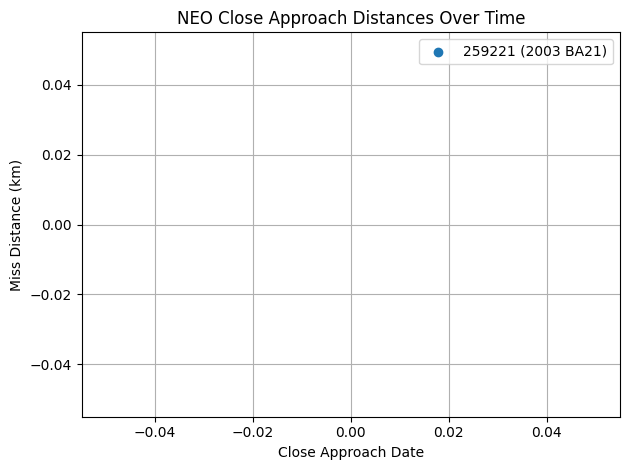

In [28]:
def main():
  asteroid_list = asteroids_from_neo(ASTEROID_ID, ASTEROID_NAME, ORBITING_BODY, DANGEROUS)

  if asteroid_list == None:
    print(f"searched {len(neos)} asteroids\nfound 0 matches")
  else:
    print(f"searched {len(neos)} asteroids\nfound {len(asteroid_list)} matches")

    #print(f"{asteroid_list[0].close[-1]}")

    draw_graph(asteroid_list)

main()